In [1]:
# Define environment variables 
%env DEEP_ROOT=/content/drive/My Drive/brAIn-Power
%env DEEP_DATA=/content/drive/My Drive/correct_data

# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory before importing files
import os
deep_root = os.getenv("DEEP_ROOT")
%cd $deep_root

!pip install import-ipynb
import import_ipynb

env: DEEP_ROOT=/content/drive/My Drive/brAIn-Power
env: DEEP_DATA=/content/drive/My Drive/correct_data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/brAIn-Power


In [2]:
from LoadData import CustomDataset, load_data_2np,one_hot_encode,one_hot2_2d
import UNet
import torch
import time
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

importing Jupyter notebook from LoadData.ipynb
importing Jupyter notebook from UNet.ipynb


In [3]:
# Define some helper functions for later:
# def IoU_score(target, prediction):
#   iou_score = 0
#   for i in range(target.shape[0]):
#     target[i] = np.argmax(target[i])
#     prediction[i] = np.argmax(prediction[i])
#     intersection = np.logical_and(target[i], prediction[i])
#     union = np.logical_or(target[i], prediction[i])
#     iou_score += np.sum(intersection) / np.sum(union)
#   iou_score = iou_score/target.shape[0]
#   return iou_score
def IoU_score(target, prediction):
  iou_avg = 0
  for j in range(target.shape[0]):
    iou_score = 0
    no_classes = target.shape[1]
    target2 = one_hot2_2d(target[j])
    prediction2 = one_hot2_2d(prediction[j])
    for i in range(no_classes):
      cur_target = target2.flatten()
      cur_target = cur_target.astype(int)
      cur_pred = prediction2.flatten()
      cur_pred =  cur_pred.astype(int)
      target_idx = np.where(cur_target == i)
      prediction_idx = np.where(cur_pred == i)
      intersection = len(np.intersect1d(target_idx, prediction_idx))
      union = np.concatenate((target_idx, prediction_idx),axis=1)
      union = union.tolist()
      union = len(set(union[0]))
      if union != 0:
        iou_score += intersection / union
    iou_score = iou_score/no_classes
    iou_avg += iou_score 
  
  return iou_avg/target.shape[0]

In [4]:
# Load data the first time
#X_train, Y_train, X_valid, Y_valid, X_trans, Y_trans, X_test, Y_test = load_data_2np(hot_encoding=True, valid_perc=0.1, train_perc=0.1,show=0,CAD_perc=0,background=True)

In [6]:
Valid_perc = 0.05

X_train = np.load(f"data/compressed_data/with_background/X_train,.npy")
Y_train = np.load(f"data/compressed_data/with_background/Y_train,.npy")
X_trans = np.load(f"data/compressed_data/with_background/X_trans,.npy")
Y_trans = np.load(f"data/compressed_data/with_background/Y_trans,.npy")
X_test = np.load(f"data/compressed_data/with_background/X_test,.npy")
Y_test = np.load(f"data/compressed_data/with_background/Y_test,.npy")


# Y_train = np.concatenate((Y_train,Y_trans[0:100]),axis=0)
# X_train = np.concatenate((X_train,X_trans[0:100]),axis=0)
Y_train = one_hot_encode(imgs=Y_train)
Y_test = one_hot_encode(imgs=Y_test)

idx = int(Valid_perc*X_train.shape[0])
X_valid = X_train[0:idx]
X_train = X_train[idx::]

Y_valid = Y_train[0:idx]
Y_train = Y_train[idx::]

In [ ]:
# Save data for easier load next time - remember to name accodingly
# The naming scheme refers pparameters of the load_data_2np function
#np.save("data/X_train_hot_v0.1_t0.1_s0_c0_True", X_train)
#np.save("data/Y_train_hot_v0.1_t0.1_s0_c0_True", Y_train)
#np.save("data/X_valid_hot_v0.1_t0.1_s0_c0_True", X_valid)
#np.save("data/Y_valid_hot_v0.1_t0.1_s0_c0_True", Y_valid)
#np.save("data/X_trans_hot_v0.1_t0.1_s0_c0_True", X_trans)
#np.save("data/Y_trans_hot_v0.1_t0.1_s0_c0_True", Y_trans)
#np.save("data/X_test_hot_v0.1_t0.1_s0_c0_True", X_test)
#np.save("data/Y_test_hot_v0.1_t0.1_s0_c0_True", Y_test)

In [ ]:
# # Load dataset from .npy files
# data_set = "hot_v0.1_t0.1_s0_c0_True"

# X_train = np.load(f"data/X_train_{data_set}.npy")
# Y_train = np.load(f"data/Y_train_{data_set}.npy")
# X_valid = np.load(f"data/X_valid_{data_set}.npy")
# Y_valid = np.load(f"data/Y_valid_{data_set}.npy")
# X_test = np.load(f"data/X_test_{data_set}.npy")
# Y_test = np.load(f"data/Y_test_{data_set}.npy")



In [ ]:
# Load transformations if needed
#X_trans = np.load(f"data/X_trans_{data_set}.npy")
#Y_trans = np.load(f"data/Y_trans_{data_set}.npy")

In [7]:
DS_train = CustomDataset(X_train, Y_train,one_hot=True)
DS_valid = CustomDataset(X_valid, Y_valid, one_hot=True)
DS_test = CustomDataset(X_test, Y_test, one_hot=True)

In [8]:
# Clear space
del X_train
del Y_train
del X_valid
del X_trans
del Y_trans
del X_test
del Y_test

In [9]:
# Perform preprocessing
DS_train.gray_gamma_enhanced()
DS_valid.gray_gamma_enhanced()
DS_test.gray_gamma_enhanced()

In [10]:
# Check if GPU is available and functions to convert Tensors to Cuda
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

Running GPU.


In [11]:
# Load in model
%%capture
net = UNet.UNet50(n_classes=9, rgb=False)
net = net.to(torch.float)
if use_cuda:
    print('converting network to cuda-enabled')
    net.cuda()


In [12]:
# Converts tensors to cuda, if available
def get_variable(x):
    if use_cuda:
        return x.cuda()
    return x

In [13]:
# Get numpy array for both cuda and not
def get_numpy(x):
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [15]:
# Create lossfunction and optimizer
criterion = UNet.DiceLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=5e-5)

In [16]:
# Define hyper parameters
NUM_EPOCHS = 201
check_at = 10

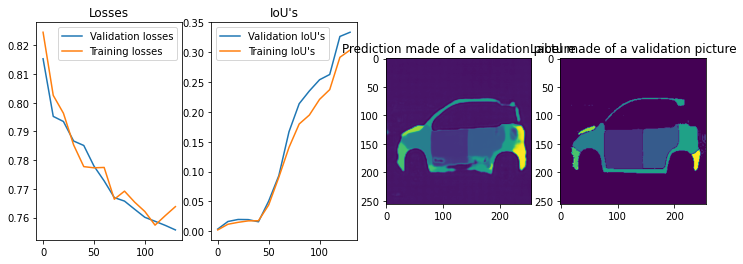

At epoch 130 Training loss is at 0.7637980878353119 and the IoU is at 0.30362278267017356%
At epoch 130 Validation loss is at 0.7556797365347544 and the IoU is at 0.3334713519476988%
train epoch 131
train epoch 132
train epoch 133


KeyboardInterrupt: ignored

In [17]:
# Define list to stor intermediat results
valid_iter = []
valid_loss = []
valid_iou = []

train_iter = []
train_loss = []
train_iou = []

# Define data loaders to serve data
# DS_train.remove_transforms()
# DS_train.transforms(p_rot=0.1,p_trans=0.1,p_zoom=0.1,p_shear=0.1)
# DL_train = DataLoader(DS_train, batch_size=16, shuffle=True)
DL_valid = DataLoader(DS_valid)

# Training loop
net.train()
for epoch in range(NUM_EPOCHS):

    print(f"train epoch {epoch}")
    # transform data and add it to the dataloader
    DS_train.transforms(p_rot=0.1,p_trans=0.1,p_zoom=0.1,p_shear=0.1)
  
    DL_train = DataLoader(DS_train, batch_size=16, shuffle=True)
    for i, data in enumerate(DL_train, 0):
        net.train()
        input = data[0].type(torch.FloatTensor)
        target = data[1].type(torch.FloatTensor)

        # Tranfer to GPU if possible
        input = get_variable(input)
        target = get_variable(target)

        # Train the network
        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()

        # Save space
        del input
        del target
        del output
        del loss
    # remove transformations so new ones can take their place.    
    

    # If we want to evaluate
    if epoch % check_at == 0:
      net.eval()

      with torch.no_grad():
        # Evaluate training
        train_losses, train_ious, train_batches = 0, 0, 0
        for i, data in enumerate(DL_train, 0):
          input = data[0].type(torch.FloatTensor)
          target = data[1].type(torch.FloatTensor)

          # Tranfer to GPU if possible
          input = get_variable(input)
          target = get_variable(target)
          
          output = net(input)

          # Record performance
          train_batches += 1
          train_losses += criterion(output, target).item()
          train_ious += IoU_score(get_numpy(target), get_numpy(output))

          # Save space
          del input
          del target
          del output

        train_iter.append(epoch)
        train_loss.append(train_losses / train_batches)
        train_iou.append(train_ious / train_batches)

        # Evaluate validation
        val_losses, val_ious, val_batches = 0, 0, 0
        once=True
        for i, valid_data in enumerate(DL_valid, 0):
            input = valid_data[0].type(torch.FloatTensor)
            target = valid_data[1].type(torch.FloatTensor)
            
            # Tranfer to GPU if possible
            input = get_variable(input)
            target = get_variable(target)
            
            output = net(input)
            if i>=np.random.randint(0,5) and once:
            #   input1 = input
            #   output1 = output
              img = one_hot2_2d(get_numpy(output[0]))[0]
              img_label = one_hot2_2d(get_numpy(target[0]))[0]
              once = False
            # Record performance
            val_batches += 1
            val_losses += criterion(output, target).item()
            val_ious += IoU_score(get_numpy(target), get_numpy(output))
            # Save space
            del input
            del target
            del output

        valid_iter.append(epoch)
        valid_loss.append(val_losses / val_batches)
        valid_iou.append(val_ious / val_batches)
        
        clear_output(wait=True)
        fig = plt.figure(figsize=(12,4))
        plt.subplot(141)
        plt.plot(valid_iter,valid_loss,label='Validation losses')
        plt.plot(train_iter,train_loss,label='Training losses')
        plt.title('Losses')
        plt.legend()

        plt.subplot(142)
        plt.plot(valid_iter,valid_iou,label='Validation IoU\'s')
        plt.plot(train_iter,train_iou,label='Training IoU\'s')
        plt.title('IoU\'s')
        plt.legend()
        
        plt.subplot(143)
        plt.imshow(img)
        plt.title('Prediction made of a validation picture')

        plt.subplot(144)
        plt.imshow(img_label)
        plt.title('Label made of a validation picture')
        plt.show()
        print(f'At epoch {epoch} Training loss is at {train_loss[-1]} and the IoU is at {train_iou[-1]}%')
        print(f'At epoch {epoch} Validation loss is at {valid_loss[-1]} and the IoU is at {valid_iou[-1]}%')
    DS_train.remove_transforms()

In [ ]:
# torch.save(net,'UNet50_100of512trans_changing_240epochs')

In [ ]:
prediction = get_numpy(output1)
input      = get_numpy(input1)

plt.imshow(one_hot2_2d(prediction[0])[0])
plt.show()
plt.imshow(one_hot2_2d(Y_valid[0])[0])
plt.show()


print(IoU_score(Y_valid[0].reshape([1,9,256,256]),prediction))

In [ ]:
net.eval()
input = DS_train.data[1].reshape([1,1,256,256])
input = get_variable(torch.tensor(input).type(torch.FloatTensor))
output = net(input)

img_label = one_hot2_2d(get_numpy(output)[0])
img_pred = one_hot2_2d(DS_train.labels[1])

plt.subplot(131)
plt.imshow(img_label[0])

plt.subplot(132)
plt.imshow(img_pred[0])


plt.subplot(133)
plt.imshow(DS_train.data[1,0]-np.min(DS_train.data[1]))
plt.show()
print(np.max(DS_train.data[1]))
print(DS_train.data.shape)